In [1]:
# Standard imports
import cv2
import numpy as np;
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img = cv2.imread("blank.jpg")

[ WARN:0@2.423] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('blank.jpg'): can't open/read file: check file path/integrity


In [3]:
def find_contour(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 164, 255, cv2.THRESH_TOZERO)
    # detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    return contours

In [4]:
contours = find_contour(img)
max_cnt = max(contours, key=cv2.contourArea)
image_copy = img.copy()

cv2.drawContours(image=image_copy, contours=[max_cnt], contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)   
plt.imshow(image_copy)

error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


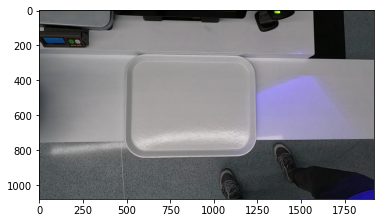

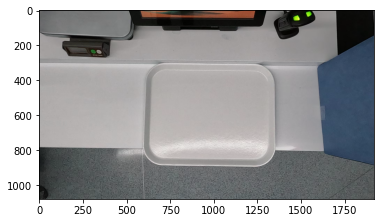

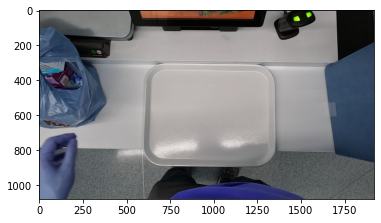

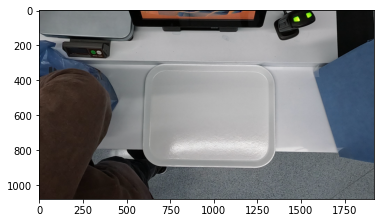

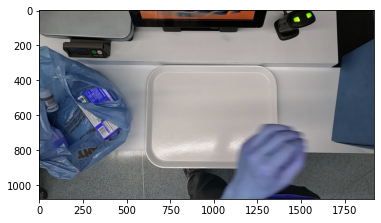

In [23]:
videos = ["testA_1.mp4","testA_2.mp4","testA_3.mp4","testA_4.mp4","testA_5.mp4",]


for video in videos:
    vs = cv2.VideoCapture(video)
    last_frame_num = vs.get(cv2.CAP_PROP_FRAME_COUNT)

    count = 5
    img_frame = None
    ret, frame = vs.read()
    plt.imshow(frame)
    plt.show()


    vs.release()

### Calculating Mean and STD

In [18]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

import matplotlib.pyplot as plt

####### PARAMS

device      = torch.device('cpu') 
num_workers = 4
image_size  = 512 
batch_size  = 8
data_path   = '../dataset/syn_image_train/'

In [43]:
class AICityDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = image_filepath.split('/')[-1]
        label = label.split("_")[0]
        label = int(label)
        if self.transform is not False:
            image = self.transform(image=image)["image"]
        return image

In [44]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk(data_path):
    f.extend(filenames)
    break
files = []
for filename in f:
    files.append(data_path+filename)

train_transforms = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Normalize(
            mean = (0,0,0),
            std = (1,1,1)
        ),
        ToTensorV2(),
    ]
)

# dataset
image_dataset = AICityDataset(
                         image_paths= files,
                         transform=train_transforms)

# data loader
image_loader = DataLoader(image_dataset, 
                          batch_size  = batch_size, 
                          shuffle     = False, 
                          num_workers = num_workers,
                          pin_memory  = True)

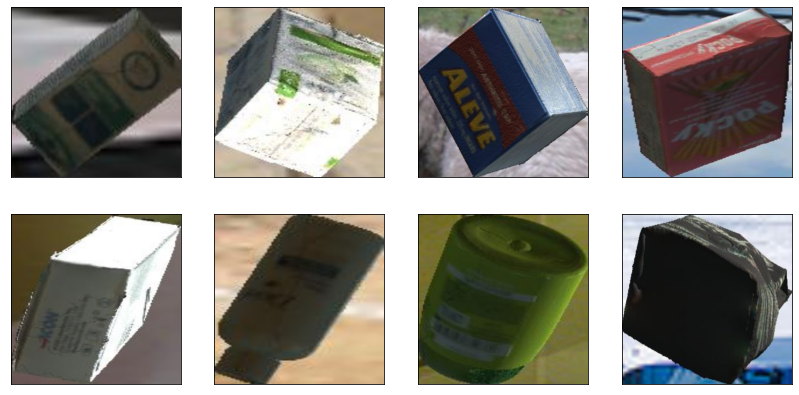

In [45]:
# display images
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

In [46]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 14563/14563 [16:37<00:00, 14.59it/s]


In [47]:
len(files)

116500

In [48]:

# pixel count
count = len(files) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4124, 0.3856, 0.3493])
std:  tensor([0.2798, 0.2703, 0.2726])


  0%|          | 0/1799 [00:00<?, ?it/s]

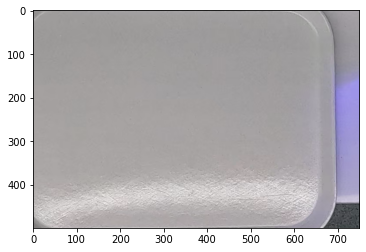

  0%|          | 0/1499 [00:00<?, ?it/s]

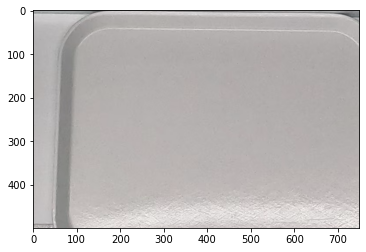

  0%|          | 0/3642 [00:00<?, ?it/s]

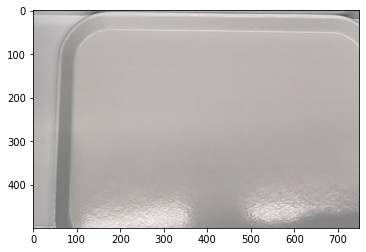

  0%|          | 0/2123 [00:00<?, ?it/s]

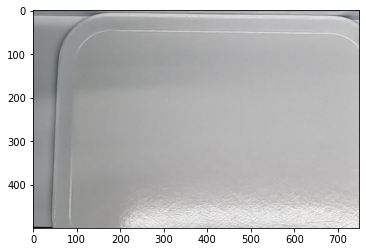

  0%|          | 0/1547 [00:00<?, ?it/s]

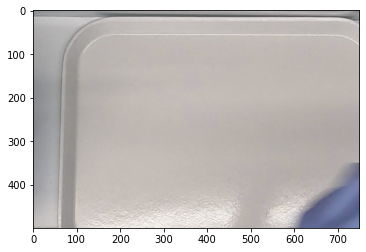

  0%|          | 0/1547 [00:00<?, ?it/s]


In [13]:
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

video_location = "../test-videos/"
videos = ["testA_1.mp4","testA_2.mp4","testA_3.mp4","testA_4.mp4","testA_5.mp4",]
images_list = []
ratios_list = []
 
for video in videos:
  vidcap = cv2.VideoCapture(video_location+video)
  fps = vidcap.get(cv2.CAP_PROP_FPS)      
  frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
  resized_image = []

  for i in tqdm(range(frame_count)):
    try:
      success,image = vidcap.read()
      image = image[300:800, 550:1300]
      plt.imshow(image)
      plt.show()
      break
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      resized_image.append(image)
    except:
      pass
  ratios = []